In [1]:
import pathlib
from data_preparation.transformation_manager import TransformationManager
from raw_data_manager import models
from raw_data_manager import raw_data_acquisition as rda
from data_exploration import visualization_helper as visual
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

/home/ubuntu/lemi_3w/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X2, y2 = TransformationManager.retrieve_pair_array(pathlib.Path("data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-all_train/1/WELL-00002_20140126161944.npz"))

event2 = rda.get_event("data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train/1/WELL-00002_20140126161944.parquet")

X2.shape, y2.shape, event2.shape

((382, 20, 6), (382, 9), (24017, 9))

In [3]:
import pickle
with open("best_model.pkl",'rb') as file:
    best_model = pickle.load(file)

2023-10-26 12:53:04.570628: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 12:53:04.574225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 12:53:04.626727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:53:04.626766: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:53:04.626796: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [4]:
predictions = best_model.predict(X2)
predictions_prepared = visual.prepare_prediction_array(predictions, window_size=20, subsample_rate=60)

print(predictions.shape)
print(predictions_prepared.shape)

12/12 [==============================] - 0s 4ms/step
(382, 9)
(24060, 9)


/home/ubuntu/lemi_3w/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:5394: RuntimeWarning: overflow encountered in cast
  values = array(values, copy=False, ndmin=arr.ndim, dtype=arr.dtype)


In [17]:
def prepare_prediction_array(
    predictions: np.array, 
    window_size: int, 
    subsample_rate: int,
    length: int,
):
    num_prediction_classes = predictions.shape[1]
    predictions = np.insert(
        predictions, 0, np.empty((window_size - 1, num_prediction_classes)), axis=0
    )
    predictions = np.repeat(predictions, subsample_rate, axis=0)
    return predictions[0:length, :]

predictions_prepared = prepare_prediction_array(predictions, window_size=20, subsample_rate=60, length=event2.shape[0])
predictions_prepared.shape

(24017, 9)

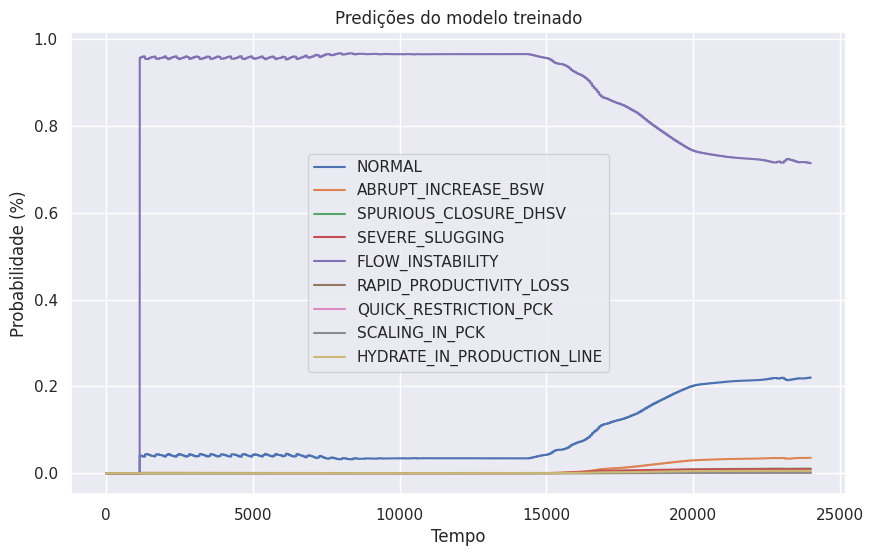

In [18]:
variable_names = [event_class_type.name for event_class_type in models.EventClassType]

# Create the line plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
for i in range(len(variable_names)):
    #sns.lineplot(y=predictions_prepared[:, i], x=event2.index, label=variable_names[i])
    sns.lineplot(data=predictions_prepared[:, i], label=variable_names[i])
    #sns.lineplot(data=predictions[:, i], label=variable_names[i])

plt.xlabel('Tempo') 
plt.ylabel('Probabilidade (%)')
plt.title('Predições do modelo treinado')
plt.legend()
plt.show()

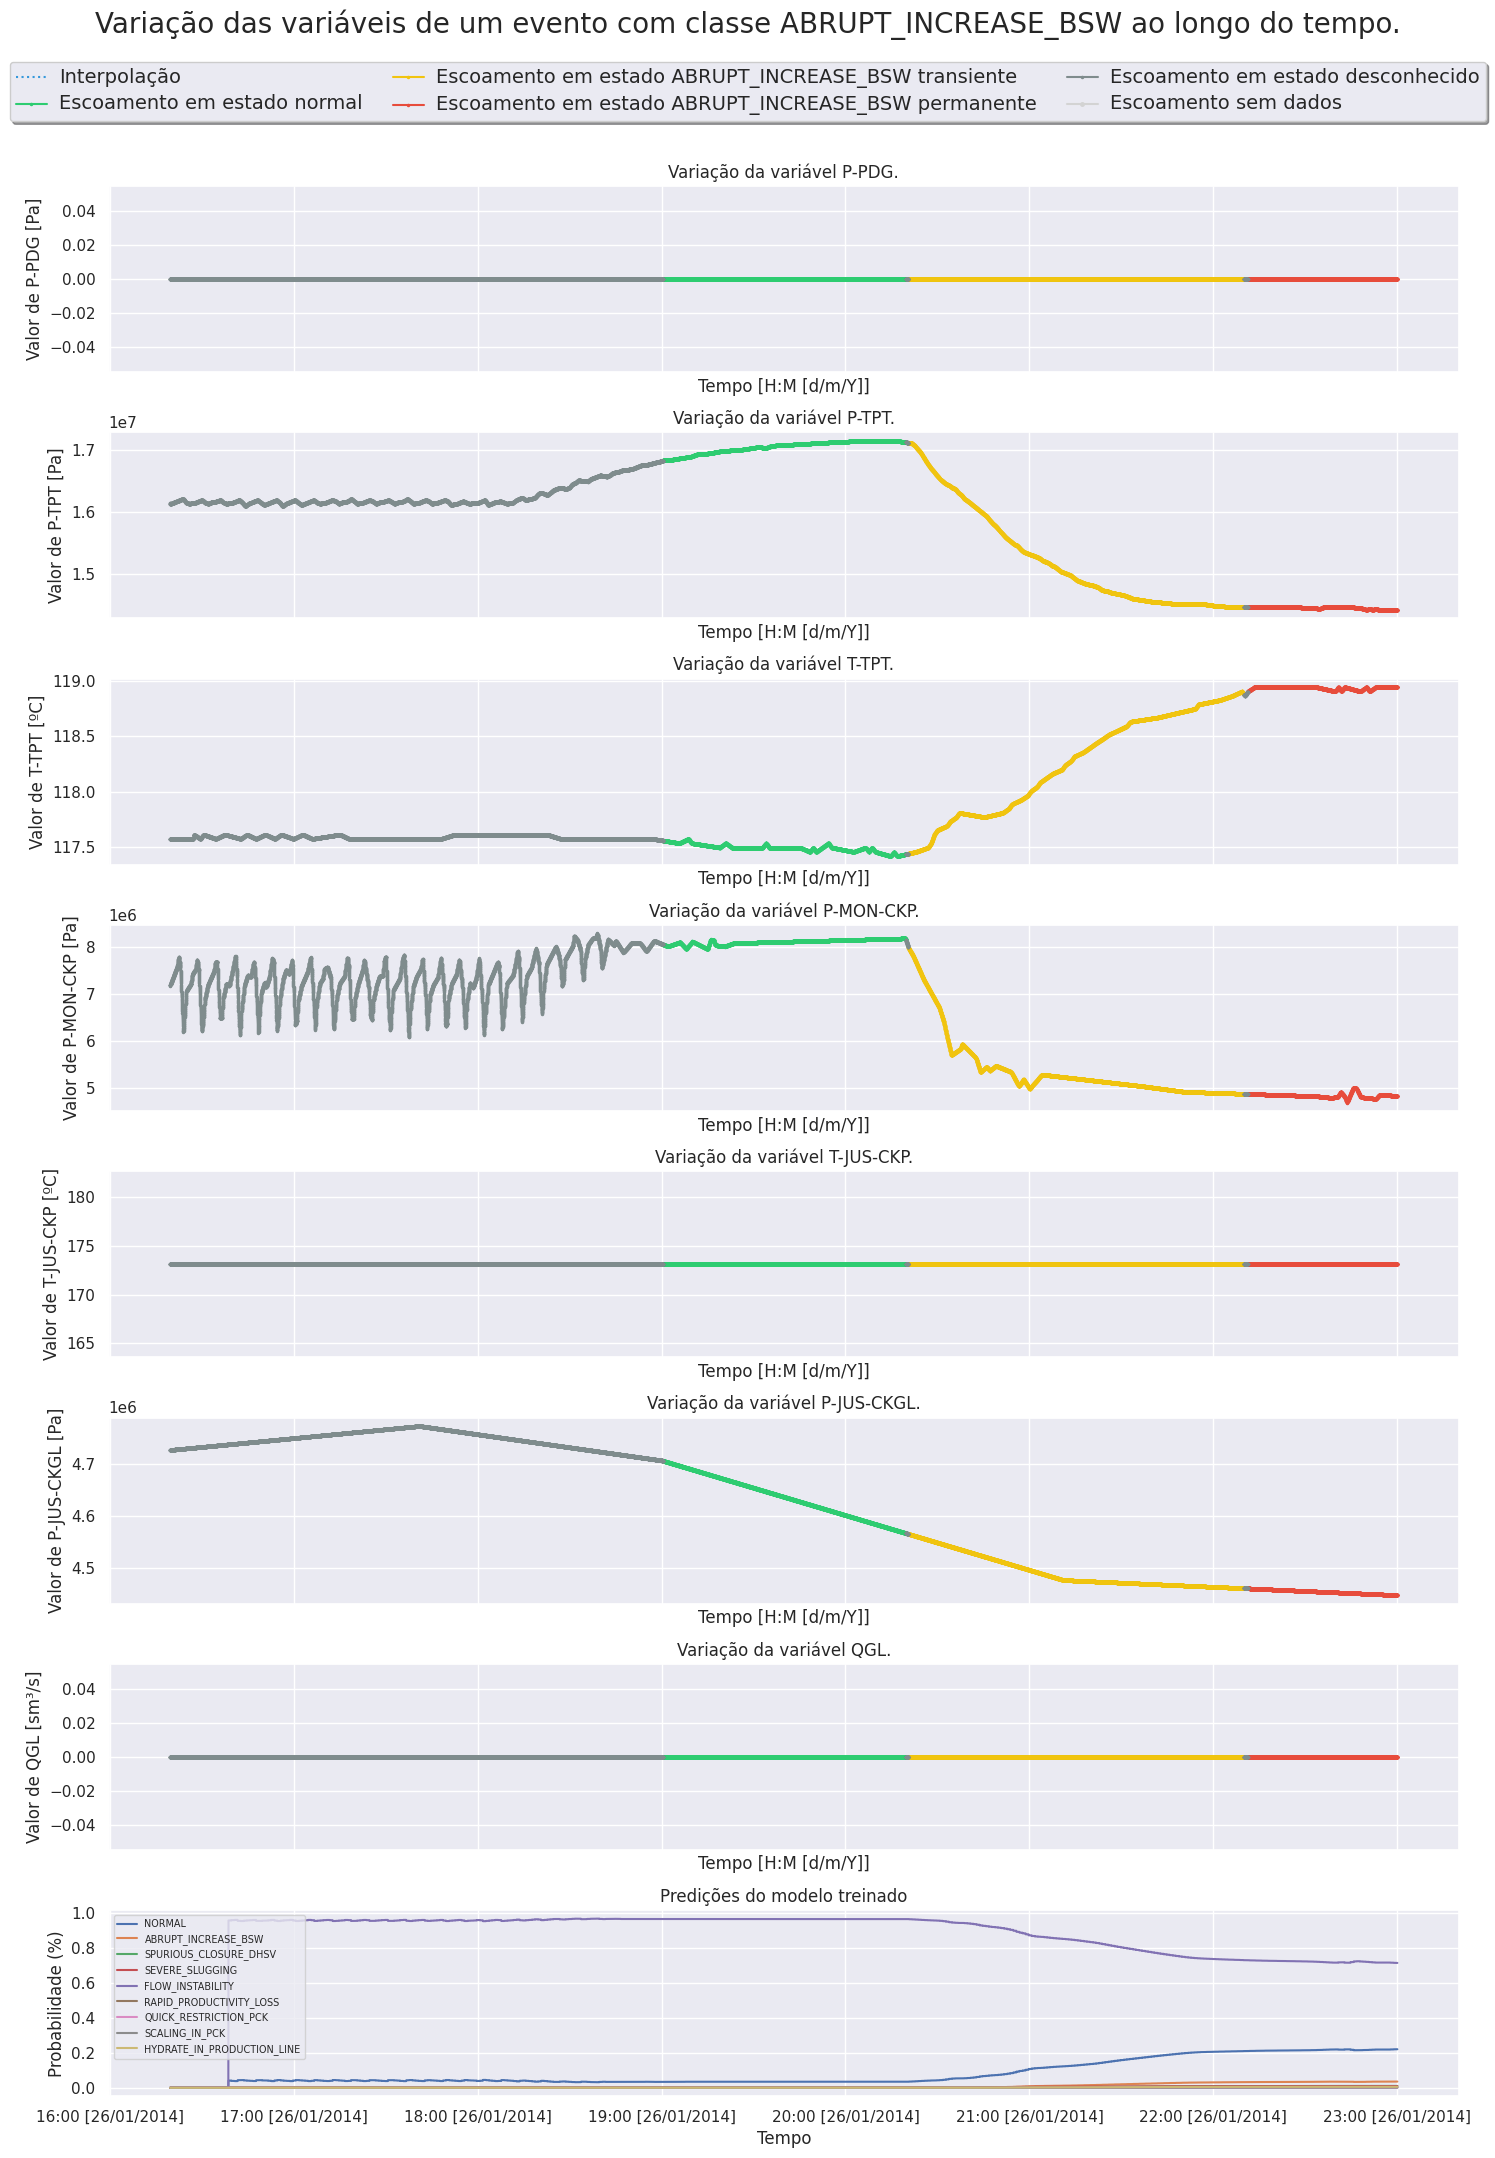

In [19]:
variable_names = [event_class_type.name for event_class_type in models.EventClassType]
visual.display_entire_event(
    event2,
    models.EventClassType(1).name,
    predictions_prepared,
    variable_names,
    True, 'linear', language='pt')